# Simulation 01 - Base Case

#### Import libraries

In [1]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx 

# Random and distribution for simulating
import random

# Create the simpy environment
env = simpy.Environment()

### Define the graph

In [2]:
# Graph location
location_graph = "Shape-Files/Rotterdam-Antwerpen-corridor"
name_graph = "edges_2.shp"

##  create a graph of the loaded data, 
FG = nx.read_shp(os.path.join(location_graph, name_graph), simplify=True)
graph = graph_module.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

HEIGHT_RESTRICED_NODES = {'77': 8.7}
CLOSED_NODES = [143 ,365, 73, 208]
MOVABLE_BRIDGES = [340, 103]

# Define locks
Lock = type('Lock',(core.Identifiable, core.Log, core.IsLock, core.HasResource), {})

LOCKS = [
    Lock(**{'env': env, 'name':"Krammerlock", 'lock_name':"Krammerlock",'nodes':[178,179], 'neighbour_lock':[317, 365],'lock_length':280,'lock_width':24, 'doors_open': 60, 'doors_close':60, 'operating_time':1680, 'nr_resources':3, 'priority': True}), 
    Lock(**{'env': env, 'name':"Hansweertlock",'lock_name':"Hansweertlock",'nodes':[220,221], 'neighbour_lock':[208, 209], 'lock_length':280,'lock_width':24, 'doors_open': 60, 'doors_close':60, 'operating_time':780, 'nr_resources':3, 'priority': True}), 
    Lock(**{'env': env, 'name':"Kreekraklock",'lock_name':"Kreekraklock",'nodes':[155, 156], 'neighbour_lock':[73,72], 'lock_length':320,'lock_width':24, 'doors_open': 60, 'doors_close':60, 'operating_time':480, 'nr_resources':3, 'priority': True}),
    Lock(**{'env': env, 'name':"Krammerlock",'lock_name':"Krammerlock",'nodes':[317, 365], 'neighbour_lock':[178,179],'lock_length':280,'lock_width':24, 'doors_open': 60, 'doors_close':60, 'operating_time':1680, 'nr_resources':3, 'priority': True}), 
    Lock(**{'env': env, 'name':"Hansweertlock",'lock_name':"Hansweertlock",'nodes':[208, 209], 'neighbour_lock':[220,221], 'lock_length':280,'lock_width':24, 'doors_open': 60, 'doors_close':60, 'operating_time':780, 'nr_resources':3, 'priority': True}), 
    Lock(**{'env': env, 'name':"Kreekraklock",'lock_name':"Kreekraklock",'nodes':[73,72], 'neighbour_lock':[155, 156], 'lock_length':320,'lock_width':24, 'doors_open': 60, 'doors_close':60, 'operating_time':480, 'nr_resources':3, 'priority': True})
]

In [3]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    distance = wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
    return distance


def get_lock(node_one, node_two):
    for lock in LOCKS:
        nodes_lock = lock.nodes
        if node_one in nodes_lock and node_two in nodes_lock:
            return lock
    return None

#new
def get_bridge(index):
    if index in MOVABLE_BRIDGES:
        return True
    return False


def get_slow_down(index):
    if (get_bridge(index)):
        return True
    for lock in LOCKS:
        if index in lock.nodes:
            return True
    return False
    

def get_height_restriction(index):
    '''
    Restriction in meters for a node, vessel can only pass if height < restriction
    '''
    if (str(index) in HEIGHT_RESTRICED_NODES.keys()):
        print("found restriction {}".format(HEIGHT_RESTRICED_NODES[str(index)]))
        return HEIGHT_RESTRICED_NODES[str(index)]
    return 99

def get_closed(index):
    if index in CLOSED_NODES:
        return True
    return False

          
def do_nodes():
    for i, node in enumerate(FG.nodes(data = True)):
        graph.graph.add_node(i, pos = node[0], 
                        height_restriction = get_height_restriction(i),
                        closed = get_closed(i),
                        name = "Node {}".format(i),
                        bridge = get_bridge(i),
                        slow_down = get_slow_down(i),
                        geometry = shapely.geometry.Point(node[0][0], node[0][1]))

        lat_lon_to_index[node[0]] = i
        

def do_edges():
    for edge in FG.edges(data=True):
        edge_type = 'Canal'
        lock = get_lock(lat_lon_to_index[edge[0]],lat_lon_to_index[edge[1]])
        edge_attribute = None
        resource = simpy.Resource(env, capacity = math.inf)
        if (lock != None):
            edge_type = 'Lock'
            edge_attribute = lock
            resource = lock.resource
            print(lock.name)
        graph.graph.add_edge(lat_lon_to_index[edge[0]], 
                     lat_lon_to_index[edge[1]],
                     Object=edge_type,
                     dis= calculate_distance(nx.get_node_attributes(graph.graph, 'geometry')[lat_lon_to_index[edge[1]]], 
                                             nx.get_node_attributes(graph.graph, 'geometry')[lat_lon_to_index[edge[0]]]),
                     weight = 1,
                     Resources = resource,
                     attribute = edge_attribute
                    )

        
do_nodes()
do_edges()

FG = graph.graph
FG_S = graph.graph.to_directed()

found restriction 8.7
Kreekraklock
Kreekraklock
Krammerlock
Hansweertlock
Hansweertlock
Krammerlock


In [4]:
## Grapgh obtained from FG from build graph

def path_length(some_path):
    wgs84 = pyproj.Geod(ellps='WGS84')
    some_path_dist = 0
    for node in enumerate(some_path):
        orig = nx.get_node_attributes(FG, "geometry")[some_path[node[0]]]
        dest = nx.get_node_attributes(FG, "geometry")[some_path[node[0] + 1]]
        some_path_dist += wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                         shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2]
        if node[0] + 2 == len(some_path):
                    break
    return some_path_dist

def get_restrictions(path, graph):
    """
    Pickup all restrictions for a given path
    Restrictions are put on the nodes when creating the graph. 
    Now loop over the nodes and check if they have a restriction.
    Restrictions like height or closed nodes but others are possible too.
    """
    restrictions = {'closed':False, 'height': 99}
    height_restriction_on_graph = nx.get_node_attributes(graph, 'height_restriction')
    closed_nodes = nx.get_node_attributes(graph, 'closed')
    for node in path:
        rest = height_restriction_on_graph[node]
        if rest < restrictions['height']:
            restrictions['height'] = rest
        if closed_nodes[node]:
            restrictions['closed'] = True
    return restrictions    
    
class NodePath():
    """
    This object contains some more info about the path
    like: restrictions, length in m etc. 
    Can be used later when selecting proper path for a vessel.
    """
    def __init__(self, path, graph, indentifier):
        self.nodes = path
        self.length = path_length(path)
        self.name = "Path_{}".format(indentifier)
        # get restrictions for the nodes
        restrictions = get_restrictions(path, graph)
        self.max_height = restrictions['height']
        self.closed = restrictions['closed']
        
    def __type__(self):
        return "node_path" 
    
    def __str__(self):
        return "from node {} to  node {}, covering distance: {}, closed:{}, max height: {}".format(self.nodes[-1], self.nodes[0] ,self.length, self.closed, self.max_height)
    def plot(self, graph, save=False, filename=''):
        """
        Plot the path
        """
        locks = [178, 179, 220, 221, 155, 156]
        #new
        bridges = [340,103]
        for key in dict(graph.nodes):
            graph.nodes[key]["Path"] = 0.5
            graph.nodes[key]["Color"] = "Red"
            for i, node in enumerate(self.nodes):
                if key == node:
                    if i == 0:
                        graph.nodes[key]["Path"] = 200
                        graph.nodes[key]["Color"] = "Yellow"
                    elif i == len(self.nodes) - 1:
                        graph.nodes[key]["Path"] = 200
                        graph.nodes[key]["Color"] = "Blue"
                    elif node in locks:
                        # here we give other color to the locks
                        graph.nodes[key]["Path"] = 300
                        graph.nodes[key]["Color"] = "Red"
                    elif node in bridges:
                        graph.nodes[key]["Path"] = 300
                        graph.nodes[key]["Color"] = "Orange"
                    else:
                        graph.nodes[key]["Path"] = 50
                        graph.nodes[key]["Color"] = "Green"
                        break

        plt.figure(figsize=(18,18))
        nx.draw(graph, nx.get_node_attributes(graph, 'pos'), 
                with_labels = True, 
                node_size = list(dict(nx.get_node_attributes(graph, 'Path')).values()), 
                font_size = 3, 
                node_color = list(dict(nx.get_node_attributes(graph, 'Color')).values()), 
                width = 0.4, 
                arrowsize = 10)
        if (save):
            plt.savefig('img/' + filename + '.png')
        plt.show()

# Get all simple paths (which are lists of nodes)
# Take the list of nodes and put it in a NodePath object as shown above
# This object contains some more info about the path
# like: restrictions, length in m etc. 

paths = []
i = 1
for path in nx.all_simple_paths(FG_S, 263, 41): # simplepaths geeft lijst met node nummers
    #paths.append(NodePath(path, FG_S, i)) # maak van ieder lijst met nodes een NodePath obect en stop het in lijst
    #i+=1
    if i == 2:
        paths.append(NodePath(path, FG_S, "SR"))
        
    elif i == 15:
        paths.append(NodePath(path, FG_S, "ZB"))
     #new for bathseroute !!!  
    elif i == 5:
        paths.append(NodePath(path, FG_S, "BC"))
        
    else: paths.append(NodePath(path, FG_S, i)) # maak van ieder lijst met nodes een NodePath obect en stop het in lijst
    i+=1
        
    
# this returns al the node paths sorted on length (shortest path first)
ordered_paths = sorted(paths, key=lambda paths: paths.length)

## Create Vessels from DB

In [5]:
vessel_db = pd.read_csv("Results/Vessels.csv")
vessel_db.head()

,VesselID,width,length,height,height_loaded,emissionfactor,power,own_weight,loaded_capacity,capacity_unloaded,loaded_speed,speed_unloaded,loaded_resistance,resistance_unloaded,is_loaded,vessel_type,scenario
0,29a24858-4a51-11e9-9792-b469212bff5b,11.40,110.0,4.0,9.10,0.70,318.0,100.0,2711.0,0.0,3.7777,5.3333,106453.0,61526.0,0.0,M8,['Unmanned']
1,3254257e-4a51-11e9-8548-b469212bff5b,11.40,110.0,4.0,9.10,0.70,318.0,100.0,2711.0,0.0,3.7777,5.3333,106453.0,61526.0,1.0,M8,['Unmanned']
2,dcc05ff4-4972-11e9-a543-b469212bff5b,5.05,38.5,2.0,5.25,0.73,36.0,80.0,260.0,0.0,3.0830,4.4700,16919.0,9188.0,0.0,M1,"['Base Case', 'NS-High', 'NS-Low']"
3,dcc05ff4-4972-11e9-a543-b469212bff5b,5.05,38.5,2.0,5.25,0.73,36.0,80.0,260.0,0.0,3.0830,4.4700,16919.0,9188.0,1.0,M1,"['Base Case', 'NS-High', 'NS-Low']"
4,e6cea50a-4972-11e9-a1f1-b469212bff5b,6.06,55.0,2.0,6.10,0.72,118.0,90.0,422.5,0.0,3.3610,4.6380,28770.0,17524.0,0.0,M2,"['Base Case', 'NS-High', 'NS-Low']"


In [6]:
def init_random_vessel(routes, vessel_database, number, scenario):
    """Initialize a random vessel - parameters obtained from database"""
    
    vessel_data = {"env": None}
    
    TransportResource = type('Ship', 
                             (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                              core.HasEnergy, core.HasRestrictions,
                              core.HasResource, core.Routeable), 
                             {})
    
    # Select random vessel from database
    rows = []

    for row, entry in enumerate(vessel_db["scenario"]):
        if scenario not in entry:
            rows.append(row)

    vessel_database = vessel_database.drop(rows)
    
    vessel_info = vessel_database.sample(n = 1)
    vessel_data["name"] = "Vessel " + str(number)
    vessel_data["id"] = vessel_info["VesselID"].values[0]
    
    
    # Select a random route - taking restrictions in mind
    correction = 0
    
    if random.random() < 0.35:
        correction = 8.7
    
    vessel_data["loaded"] = vessel_info["is_loaded"].values[0]
    vessel_data["length"] = vessel_info["length"].values[0]
    vessel_data["width"] = vessel_info["width"].values[0]
    
    for path in routes:
        if path.closed:
            continue
        
        if vessel_data["loaded"]:
            vessel_data["height"] = vessel_info["height_loaded"].values[0]
            vessel_data["resistance"] = vessel_info["loaded_resistance"].values[0]
            speed = vessel_info["loaded_speed"].values[0]
            
            if vessel_data["height"] >= path.max_height or correction >= path.max_height:
                continue
        
        else:
            vessel_data["height"] = vessel_info["height"].values[0]
            vessel_data["resistance"] = vessel_info["resistance_unloaded"].values[0]
            speed = vessel_info["speed_unloaded"].values[0]
            
            if vessel_data["height"] >= path.max_height or correction >= path.max_height:
                continue
        
        break
    
    # 50/50 choses different direction
    if random.random() < 0.5:
        vessel_data["route"] = path.nodes[::-1]
        vessel_data["complete_path"] = path
    else:
        vessel_data["route"] = path.nodes
        vessel_data["complete_path"] = path
    
    vessel_data["geometry"] = vessel_data["route"][0]
    
    # Initialize remaining vessel properties
    vessel_data["length"] = vessel_info["length"].values[0]
    
    def compute_v_provider(v_empty, v_full):
        return lambda x: (v_empty + v_full) / 2
    
    vessel_data["compute_v"] = compute_v_provider(speed, speed)
    vessel_data["emissionfactor"] = vessel_info["emissionfactor"].values[0]
    vessel_data["capacity"] = vessel_info["loaded_capacity"].values[0]
    
    return TransportResource(**vessel_data)

### Run simulation

In [7]:
def start(env, vessel):
    while True:
        
        vessel.log_entry("Start sailing", env.now, "0", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "0", vessel.geometry)

        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [8]:
%%time

# Add graph to environment
env.FG = FG

env.paths = {}

# 24hours
SIM_TIME = 24*60*60
vessels = []

# Simulation scenario
high = [6, 6, 7, 9, 10, 13, 14, 15, 16, 19, 19, 20, 20, 18, 17, 16, 15, 14, 13, 10, 9, 7, 6, 6]
low  = [6, 6, 7, 9, 10, 13, 14, 15, 16, 18, 19, 20, 20, 18, 17, 16, 15, 14, 12, 10, 9, 7, 6, 6]
now  = [5, 6, 7, 9, 9, 11, 13, 15, 15, 16, 18, 20, 20, 20, 19, 18, 14, 13, 13, 11, 10, 6, 6, 5]

scenario = "Base Case"

def pois(t, ship_distribution):
    hour = int((t%(24*3600))/3600)
    average_on_hour = ship_distribution
    number_of_boats_this_hour = np.random.normal(average_on_hour[hour])
    if number_of_boats_this_hour == 0:
        return 0
    return 60 * 60 / number_of_boats_this_hour

def setup(env, distribution, ship_distribution, scenario):
    # initial vessel
    i = 1
    vessel = init_random_vessel(ordered_paths, vessel_db, i, scenario)
    vessel.env = env
    vessel.geometry = nx.get_node_attributes(FG, "geometry")[vessel.route[0]]
    env.process(start(env, vessel))
    vessels.append(vessel)

    while True:
        #break
        # timeout before next ship is released
        i += 1
        yield env.timeout(distribution(env.now, ship_distribution))
        vessel = init_random_vessel(ordered_paths, vessel_db, i, scenario)
        vessel.env = env
        vessel.geometry = nx.get_node_attributes(FG, "geometry")[vessel.route[0]]
        env.process(start(env, vessel))
        vessels.append(vessel)
         
env.process(setup(env, pois, now, scenario))

env.crossover_points = {182: ((184, 394,154,155,156,216,217, 218), (164, 134,133, 132,73,72,71,402,401)),
                        2: ((218,217,216,156,155,154,394,184), (401, 402,71,72,73,132,133,134,164)),
                        141: ((140,139,179,178,379), (363, 364, 365, 317, 403)),
                        382: ((379,178,179,139,140), (403,317,365,364,363)),
                        273:((222,221,220,279), (272, 209, 208, 210)),
                        278: ((279,220,221,222), (210,208, 209,272))                        
}

env.run(until = SIM_TIME)

Wall time: 32.5 s


## Save all results

In [9]:
# Save location for files
save_location = "Results/"

In [10]:
# Run to get a unique id for a new simulation
import uuid
str(uuid.uuid1())

'04bfeb98-6a56-11e9-aeb5-2016b9e33e9b'

In [11]:
# to add information to dataframes
def append_dataframe(save_location, object_id, overwrite = False):
    """
    Check if dataframe is alfready filled with information, if not append.
    If it is filled with similar values, raise an error unless self.overwrite == True.
    """
    
    try:
        existing_df = pd.read_csv(save_location + "simulations.csv")
    except FileNotFoundError:
        existing_df = pd.DataFrame.from_dict({"SimulationID": [], "SimulationName": []})

    if object_id.id not in list(existing_df["SimulationID"]):
        existing_df = existing_df.append({"SimulationID": object_id.id, "SimulationName": object_id.name}, ignore_index=True)
        
    elif overwrite == True:
        existing_df = existing_df[existing_df["SimulationID"] != object_id.id]
        existing_df = existing_df.append({"SimulationID": object_id.id, "SimulationName": object_id.name}, ignore_index=True)
        
    else:
        raise KeyError("Simulation ID or simulation name already exist. " + 
                        "If you wish to overwrite the existing data, set overwrite to True")

    return existing_df

In [12]:
def get_simulation_information(save_location, env, vessels, overwrite = False):
    """
    Create a dataframe from all equipment logs
    """

    object_dict = {"SimulationID": [], 
                   "VesselID": [], 
                   "Energy": [], 
                   "Energy stationary": [],
                   "Emission": [], 
                   "Emission stationary": [],
                   "Sailed distance": [],
                   "Sailed loaded":[],
                   "Time": [], 
                   "Waiting": [], 
                   "Path": [],
                   "Loaded": [],
                   "Moved capacity": []}
    
    try:
        unique_df = pd.read_csv(save_location + "simulation_results.csv")
    except FileNotFoundError:
        unique_df = pd.DataFrame.from_dict(object_dict)

    for vessel in vessels:
        object_dict["SimulationID"].append(env.id)
        object_dict["VesselID"].append(vessel.id)
        object_dict["Path"].append(vessel.complete_path.name.replace("Path_", ""))
        
        duration = (vessel.log["Timestamp"][-1] - vessel.log["Timestamp"][0]) / 3600
        object_dict["Time"].append(duration)
        
        waiting = 0
        for i, log in enumerate(vessel.log["Message"]):
            log_clean = log.replace(" start", "")
            log_clean = log_clean.replace(" stop", "")
            
            if log_clean in ["waiting to pass bridge", "waiting to pass lock", "waiting to pass edge", "Wld: waiting doors opening", "Wld: waiting converting chamber", "Wld: doors closing"]:
                waiting_start = vessel.log["Timestamp"][i]
                
                for j, log_stop in enumerate(vessel.log["Message"][i::]):
                    if log_stop.replace(" stop", "") == log_clean:
                        waiting_stop = vessel.log["Timestamp"][i + j]
                        waiting += waiting_stop - waiting_start
                        break
        
        object_dict["Waiting"].append(waiting / 3600)
        
        vessel.calculate_energy_consumption()
        object_dict["Energy"].append(vessel.energy_use["total_energy"])
        object_dict["Energy stationary"].append(vessel.energy_use["stationary"])
        object_dict["Emission"].append(vessel.emissionfactor * vessel.energy_use["total_energy"])
        object_dict["Emission stationary"].append(vessel.emissionfactor * vessel.energy_use["stationary"])
        object_dict["Sailed distance"].append(vessel.sailed_distance)
        
        loaded = 1 if vessel.loaded else 0
        object_dict["Loaded"].append(loaded)
        object_dict["Moved capacity"].append(vessel.container.capacity * loaded)
        object_dict["Sailed loaded"].append(vessel.sailed_distance * loaded)

    # Create durations column
    object_df = pd.DataFrame.from_dict(object_dict)

    # Check if combination of simulation ID and object ID already exists
    if len(unique_df["SimulationID"]) == 0:
        unique_df = object_df

    elif not (unique_df["SimulationID"] == env.id).any():
        unique_df = pd.concat([unique_df, object_df], ignore_index = True)

    elif overwrite == True:
        drop_rows = []

        for i, row in enumerate(unique_df["SimulationID"] == env.id):
            if row == True:
                drop_rows.append(i)

        unique_df = unique_df.drop(drop_rows, axis = 0)
        unique_df = pd.concat([unique_df, object_df], ignore_index = True)

    else:
        raise KeyError("Simulation ID or simulation name already exist. " + 
                       "If you wish to overwrite the existing data, set overwrite to True")

    return unique_df

#### Save simulation

In [13]:
# Simulation information
env.name = "Base Case"
env.id = "91f6fbda-5517-11e9-8422-2016b9e33e9b"

unique_simulations = append_dataframe(save_location, env, overwrite = True)
unique_simulations.to_csv(save_location + "simulations.csv", index = False)

#### Save vessel information

In [14]:
unique_simulation_results = get_simulation_information(save_location, env, vessels, overwrite = True)
unique_simulation_results.to_csv(save_location + "simulation_results.csv", index = False)

C:\Users\leo1_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [15]:
"""
print(vessel_db.vessel_type)
#print(vessel_db.is_loaded)
print(vessel_db)


vessels[26].complete_path.plot(FG, False, vessels[26].name)
print(vessels[26].complete_path.name)
print(vessel_db.vessel_type[26])
print(vessel_db.is_loaded[26])
print(vessel_db.height[26])

vessels[54].complete_path.plot(FG, False, vessels[54].name)
print(vessels[54].complete_path.name)
print(vessel_db.vessel_type[27])
print(vessel_db.is_loaded[27])
print(vessel_db.height[27])


vessels[31].complete_path.plot(FG, False, vessels[31].name)
print(vessels[31].complete_path.name)
print(vessel_db.vessel_type[31])
print(vessel_db.is_loaded[31])
print(vessel_db.height_loaded[31])

vessels[62].complete_path.plot(FG, False, vessels[62].name)
print(vessels[62].complete_path.name)
print(vessel_db.vessel_type[31])
print(vessel_db.is_loaded[31])
print(vessel_db.height_loaded[31])




vessels[0].complete_path.plot(FG, False, vessels[0].name)
print(vessels[0].complete_path.name)
print(vessel_db.vessel_type[0])
print(vessel_db.is_loaded[0])

vessels[116].complete_path.plot(FG, False, vessels[116].name)
print(vessels[116].complete_path.name)
print(vessel_db.vessel_type[0])
print(vessel_db.is_loaded[0])




vessels[1].complete_path.plot(FG, False, vessels[1].name)
print(vessels[1].complete_path.name)
print(vessel_db.vessel_type[1])
print(vessel_db.is_loaded[1])
print(vessel_db.height_loaded[1])

"""


'\nprint(vessel_db.vessel_type)\n#print(vessel_db.is_loaded)\nprint(vessel_db)\n\n\nvessels[26].complete_path.plot(FG, False, vessels[26].name)\nprint(vessels[26].complete_path.name)\nprint(vessel_db.vessel_type[26])\nprint(vessel_db.is_loaded[26])\nprint(vessel_db.height[26])\n\nvessels[54].complete_path.plot(FG, False, vessels[54].name)\nprint(vessels[54].complete_path.name)\nprint(vessel_db.vessel_type[27])\nprint(vessel_db.is_loaded[27])\nprint(vessel_db.height[27])\n\n\nvessels[31].complete_path.plot(FG, False, vessels[31].name)\nprint(vessels[31].complete_path.name)\nprint(vessel_db.vessel_type[31])\nprint(vessel_db.is_loaded[31])\nprint(vessel_db.height_loaded[31])\n\nvessels[62].complete_path.plot(FG, False, vessels[62].name)\nprint(vessels[62].complete_path.name)\nprint(vessel_db.vessel_type[31])\nprint(vessel_db.is_loaded[31])\nprint(vessel_db.height_loaded[31])\n\n\n\n\nvessels[0].complete_path.plot(FG, False, vessels[0].name)\nprint(vessels[0].complete_path.name)\nprint(ves

In [16]:
vessel_log = pd.DataFrame.from_dict(vessels[1].log)
#
print(vessel_log.to_string())
print(len(vessels))

                                     Message     Timestamp Value                              Geometry
0                              Start sailing    856.857381     0          POINT (4.4027792 51.6880539)
1    Sailing from node 263 to node 264 start    856.857381     0          POINT (4.4027792 51.6880539)
2     Sailing from node 263 to node 264 stop    912.395450     0          POINT (4.4000023 51.6864487)
3    Sailing from node 264 to node 248 start    912.395450     0          POINT (4.4000023 51.6864487)
4     Sailing from node 264 to node 248 stop    962.490425     0          POINT (4.3985059 51.6845369)
5    Sailing from node 248 to node 174 start    962.490425     0          POINT (4.3985059 51.6845369)
6     Sailing from node 248 to node 174 stop   1143.395551     0          POINT (4.3893096 51.6794118)
7    Sailing from node 174 to node 171 start   1143.395551     0          POINT (4.3893096 51.6794118)
8     Sailing from node 174 to node 171 stop   1168.759201     0         

In [235]:
vessel_log = pd.DataFrame.from_dict(vessels[7].log)
#
print(vessel_log.to_string())
print(len(vessels))

                                     Message     Timestamp Value                               Geometry
0                              Start sailing   4978.424717     0           POINT (4.3007857 51.3503648)
1      Sailing from node 41 to node 43 start   4978.424717     0           POINT (4.3007857 51.3503648)
2       Sailing from node 41 to node 43 stop   5056.594501     0           POINT (4.2984587 51.3472541)
3      Sailing from node 43 to node 47 start   5056.594501     0           POINT (4.2984587 51.3472541)
4       Sailing from node 43 to node 47 stop   5100.153655     0           POINT (4.2982523 51.3453443)
5      Sailing from node 47 to node 81 start   5100.153655     0           POINT (4.2982523 51.3453443)
6       Sailing from node 47 to node 81 stop   5221.211943     0           POINT (4.2898218 51.3459962)
7      Sailing from node 81 to node 94 start   5221.211943     0           POINT (4.2898218 51.3459962)
8       Sailing from node 81 to node 94 stop   5325.984997     0

In [18]:
# this way I can see activity at lock
for edge in FG.edges(data=True):
    if (edge[2]["Object"] == "Lock"):
        lock_log = pd.DataFrame.from_dict(edge[2]["attribute"].log)
        print(edge[2]["attribute"].lock_name,edge[2]["attribute"].nodes, lock_log)

Kreekraklock [73, 72]            Message     Timestamp       Value  \
0     Ship in lock   7522.009601    Vessel 1   
1     Ship in lock   7966.605262    Vessel 6   
2     Ship in lock   8644.893159    Vessel 2   
3    Ship out lock   8722.009601    Vessel 1   
4    Ship out lock   9166.605262    Vessel 6   
5    Ship out lock   9844.893159    Vessel 2   
6     Ship in lock  10546.622973   Vessel 11   
7     Ship in lock  11641.827401    Vessel 5   
8    Ship out lock  11746.622973   Vessel 11   
9     Ship in lock  11830.571130    Vessel 4   
10   Ship out lock  12841.827401    Vessel 5   
11   Ship out lock  13030.571130    Vessel 4   
12    Ship in lock  13550.598337   Vessel 17   
13    Ship in lock  14042.074960   Vessel 16   
14   Ship out lock  14750.598337   Vessel 17   
15    Ship in lock  15063.575844   Vessel 10   
16   Ship out lock  15242.074960   Vessel 16   
17    Ship in lock  15242.074960    Vessel 9   
18    Ship in lock  15710.598337   Vessel 20   
19   Ship out lock

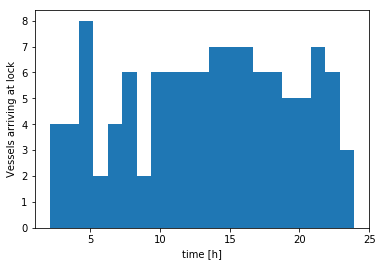

[73, 72] Kreekraklock


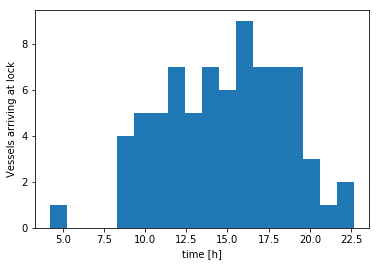

[155, 156] Kreekraklock


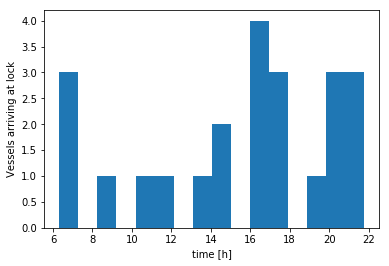

[178, 179] Krammerlock


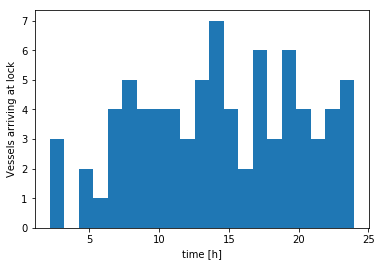

[208, 209] Hansweertlock


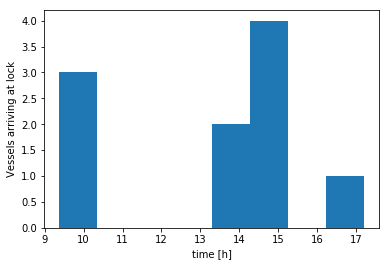

[220, 221] Hansweertlock


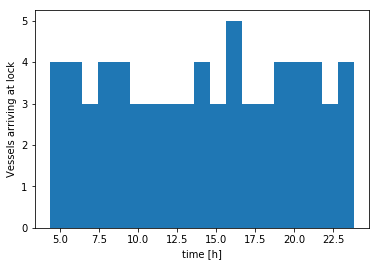

[317, 365] Krammerlock


In [19]:
# this way I can see activity at lock in graph
for edge in FG.edges(data=True):
    if (edge[2]["Object"] == "Lock"):
        edge[2]["attribute"].plot_arrivales()
        lock_log = pd.DataFrame.from_dict(edge[2]["attribute"].log)
        #print(lock_log, edge[2]["attribute"].lock_name)
        print(edge[2]["attribute"].nodes, edge[2]["attribute"].lock_name)